# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Mahdi Nobar  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

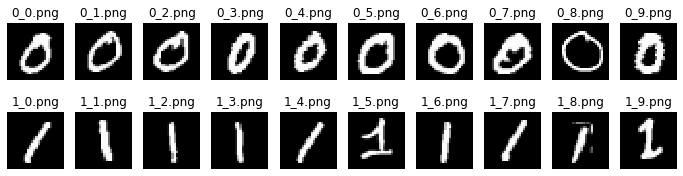

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

### 1.3 Additional method(s)

#### 1.3.1 Simple region-based descriptors

Here we analyse simple descriptors that depend on the object region :_region based descriptors_.

In [3]:
import cv2
from skimage import measure, transform, morphology
import numpy as np
from scipy import ndimage
from skimage import morphology
from skimage import measure


In [4]:
# Preparation for plotting features
def rotation(image):
    '''
    Applying rotation to get more images.
    A rotation affect the phase of all the descriptors by the same amount, and does not modify their amplitude
    '''
    rotate90d = [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate180d = [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate270d = [transform.rotate(i, 270, resize=False, preserve_range=True).astype('uint8') for i in image]
    return  list(image) + rotate90d + rotate180d + rotate270d

def featureImages(im, f1, f2):
    imageRotated = rotation(im)
    features = []
    for i in imageRotated:
        a1 = f1(i)
        a2 = f2(i)
        features.append([a1, a2])
    features = np.array(features)
    return features, [f1.__name__, f2.__name__]

def _pltF(imFeatures, features, labels):
    plt.figure(figsize=(8,8))
    for f, l, c in zip(imFeatures, labels, ['r', 'b']):
        plt.scatter(f[:,0], f[:,1], label=l, c=c, s=50)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.title('{} vs {} descriptors'.format(features[0], features[1]))
    
def plotFeatures(method1, method2):
    listImages = [zeros_im, ones_im]
    listImagesResult = []
    for im in listImages:
        imF, fName = featureImages(im, method1, method2)
        listImagesResult.append(imF)
    _pltF(listImagesResult, fName, range(len(listImages)))

##### 1.3.1.1 Compacity

Compacity is the ratio of perimeter square to the object area. It describes compactness of the object. For example, 
circle has the minimum compacity. Compycity is invariant to the rotation. 

In [5]:
def compacity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    P = measure.perimeter(thresh1>0, neighbourhood=1)
    A = np.count_nonzero(thresh1)
    C = (P**2)/A
    return C

##### 1.3.1.2 Elongation

Elongation is the ratio between  the maximum diameter of the object and its minimum diameter perpendicular to it. It is 
also invariant to the object rotation.

In [6]:
def elongation(image):
    image = ndimage.grey_opening(image,size = (2,2))
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    moment = cv2.moments(thresh1)
    xcoor = moment['mu20'] + moment['mu02']
    ycoor = 4 * moment['mu11']**2 + (moment['mu20'] - moment['mu02'])**2
    return (xcoor + ycoor**0.5) / (xcoor - ycoor**0.5)


##### 1.3.1.3 Rectangularity
Rectangularity is the ratio between the object area and its largest circumscript rectangle. 

In [7]:
def rectangularity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    _, contour, _ = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # area = cv2.contourArea(contour[0])
    area = np.count_nonzero(thresh1)
    xcoor, ycoor, width, height = cv2.boundingRect(contour[0])
    rect_area = width*height
    rectangularitY = float(area)/rect_area
    return rectangularitY

##### 1.3.1.4 Perimeter

Perimeter of the detected contour for each object is another desciptor that we would like to examine.
We first binarize each image with a threshold, and then calculate the perimeter with 1 neighbour connectivity on binary image. 

In [8]:
def perimeter(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    perimeter = measure.perimeter(thresh1>0, neighbourhood=1)
    return perimeter

##### 1.3.1.5 results and discussion
* __compacity__ vs __elongation__:<br />
According to the plot bellow compacity of 0 is larger than compacity of 1 values.  
Furthermore, elongation of number 1 images has larger variance than elongation of number 0. 
Compacity is also larger than circle compacity (4$\pi$) which is validated by our results.
Two image sets are separable in the 2D plot. Therefore, both compacity and elongation are appropriate descriptors for our images. 

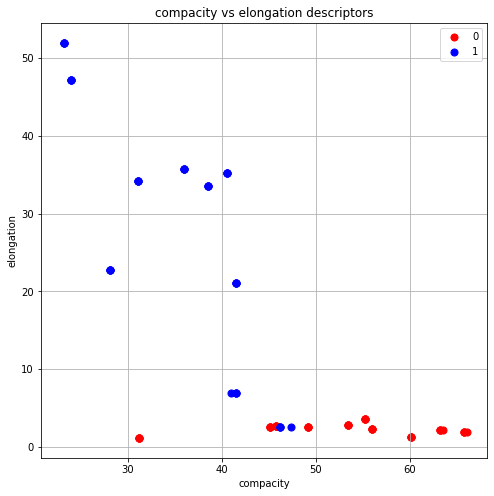

In [9]:
plotFeatures(compacity, elongation)

* __compacity__ vs __rectangularity__:<br />
According to the result, rectangularity of two image sets is not separate enough. We can conclude that rectangularity is not 
an appropriate descriptor for our data.

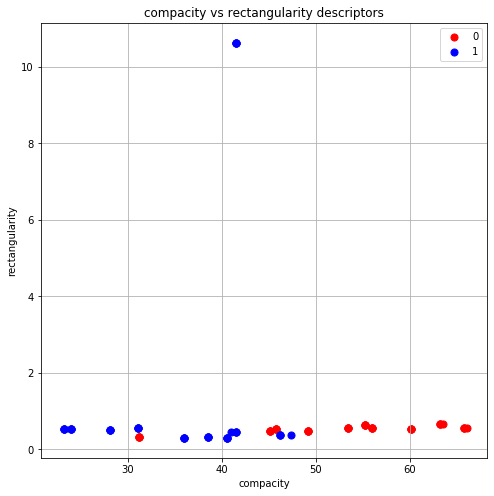

In [10]:
plotFeatures(compacity, rectangularity)

* __compacity__ vs __perimeter__:<br />
The result bellow confirms that perimeter is an appropriate descriptor for our data. Indeed, perimeter values for iamges 
number 1 and 0 are separate with each other. We can conclude that using both compacity and perimeter can provide us the 
best simple region based descriptors for our dataset.

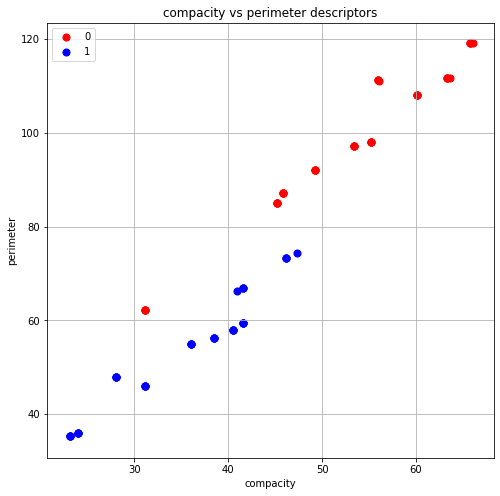

In [11]:
plotFeatures(compacity, perimeter)

#### 1.3.2 Skeleton

Here we define two skeletonization algorithms and then define and examine
descriptors to separate numbers.

##### 1.3.2.1 Medial-xis Skeletonization

We first binarize the image and inside the foreground which is supposed to contain pixels of the number we find the set of all points that each has more than
one closes point on the forwground boundary. This will render one-pixel wide skeleton of the object with the same connectivity as the original object. 
The result also is refered as _topological skeleton_:   

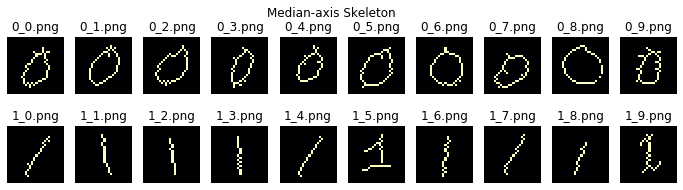

In [12]:
from skimage.morphology import medial_axis, skeletonize
import cv2
import numpy as np

skeleton_zero=[]
median_skeleton_zero=[]
median_skeleton_zero_r = []
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_zero_r.append(np.sum(r[r>1]))
    
    median_skeleton_zero.append(medial_axis(np_img))

skeleton_one=[]
median_skeleton_one = []
median_skeleton_one_r = []
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_one_r.append(np.sum(r[r>1]))
    
    median_skeleton_one.append(medial_axis(np_img))


# Plotting the skeletons
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Median-axis Skeleton')
for ax, im, nm in zip(axes[0], median_skeleton_zero, zeros_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], median_skeleton_one, ones_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)

Obviously, one descriptor that inspires extracting out ot the median skeleton is total number of the points in the skeleton.
The other descriptor that we utilize is the distance sum of the points in the object which are farther than 1 pixel from 
the background. This can be achieved by a threshold on the ditanse transform _r_ corresponding the skeleton.

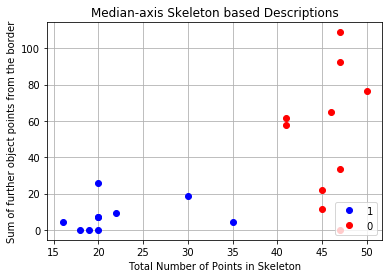

In [13]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=median_skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(median_skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
    
# Removing the first and last rows and columns from images    
_,h,w= np.shape(median_skeleton_one)
h=h-1
w=w-1
skeleton_one_check=median_skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(median_skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 

# Plotting the features plot
Plot_ones = plt.plot(Total_number_of_points1,median_skeleton_one_r, "o", label="1", c='b')
Plot_zeros = plt.plot(Total_number_of_points0,median_skeleton_zero_r, "o", label="0", c='r')
plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Sum of further object points from the border')
plt.title('Median-axis Skeleton based Descriptions')
plt.grid(True)
plt.show()

The result indicates that indeed selected descriptors can separate zero and one numbers. It shows that the total number of 
points in the median-axis skeleton is quite separating two classes regardless of existing outliers. Furthermore, the further
 object points sum from the borders of each object is overally higher for the zero objects which was expected inasmuch as 
 the object one is thinner than zero.

##### 1.3.2.2 Thinning Skeletonization

Here we utilize _fast parallel algorithm for thinning digital patterns_
invented by Zha et al. This algorithm works by making successive passes of the image, 
removing pixels on object borders. This continues until no more pixels can be removed.
 The image is correlated with a mask that assigns each pixel a number in one range of numbers 
 corresponding to each possible pattern of its 8 neighbouring pixels. Afterwards, a look up table is
  used to assign the pixels a pattern id, which are selectively removed during the iterations.

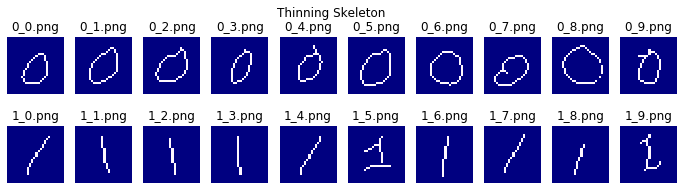

In [14]:
from skimage.morphology import medial_axis, skeletonize
import cv2
import numpy as np

skeleton_zero=[]
median_skeleton_zero=[]
median_skeleton_zero_r = []
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))

skeleton_one=[]
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))

# Plotting the skeletons
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Thinning Skeleton')
for ax, im, nm in zip(axes[0], skeleton_zero, zeros_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], skeleton_one, ones_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)

Now we have to extract two features from the skeletonized images to perform the description.
 The first feature is the number of corner pixels in each image. The corners are the yellow pixels
  that just have one yellow neighbor pixel. In order to count the corner pixels, we find the points
   which belong to skeleton and check all their neighbors. If there is just one neighbor pixel which
    also belongs to skeleton, we have to count that point as a corner.

The second feature that we used is the total number of skeleton pixels and we expect to have a higher
 number for the zeros.


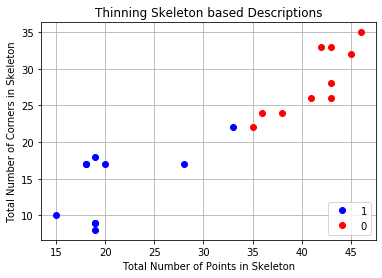

In [15]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
    
# Removing the first and last rows and columns from images    
_,h,w= np.shape(skeleton_one)
h=h-1
w=w-1
skeleton_one_check=skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 

# Plotting the features plot
Plot_ones = plt.plot(Total_number_of_points1,Total_number_of_corners1, "o", label="1", c='b')
Plot_zeros = plt.plot(Total_number_of_points0,Total_number_of_corners0, "o", label="0", c='r')
plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Total Number of Corners in Skeleton')
plt.title('Thinning Skeleton based Descriptions')
plt.grid(True)
plt.show()

 According to the result above, our skeleton method performs a good description and separation for zero and one numbers.
  In fact, _fast parallel algorithm for thinning digital patterns_ provides smoother skeleton; thereafter, the number of corners
   is also a powerful feature to separate objects utilizing thinning skeleton. Nevertheless, there are outliers due to the 
   different handwriting style.

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

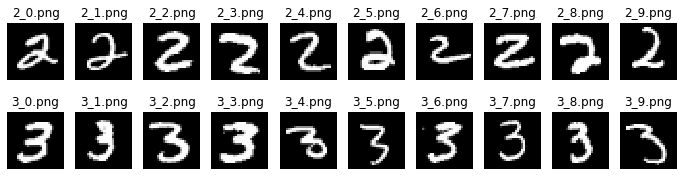

In [16]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [17]:
# Harris Corner Detector
# #%% md
###### 1.3.1.4 Corner numbers
#
#Here 
##%%
# def corner_counting(image):
#     image = ndimage.grey_opening(image,size = (2,2))
#     _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
#     # harris_dst (--> output of Harris edge detector) – Image to store the Harris detector responses.
#     harris_dst = cv2.cornerHarris(thresh1,2,3,0.04)
#     # Threshold for an optimal value, threshold value may vary depending on the image.
#     numbers = thresh1[harris_dst>0.01*harris_dst.max()].shape 
#     return numbers[0]
# 
# plotFeatures(corner_counting, compacity)
# 


### 2.3 Additional method(s)

#### 2.3.1 Simple region-based descriptors

The represntation of selected descriptors explained in part 1 are as follows:

In [18]:
import cv2
from skimage import measure, transform, morphology
import numpy as np
from scipy import ndimage
from skimage import morphology
from skimage import measure


In [19]:
# Preparation for plotting features
def rotation(image):
    '''
    Applying rotation to get more images.
    A rotation affect the phase of all the descriptors by the same amount, and does not modify their amplitude
    '''
    rotate90d = [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate180d = [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in image]
    rotate270d = [transform.rotate(i, 270, resize=False, preserve_range=True).astype('uint8') for i in image]
    return  list(image) + rotate90d + rotate180d + rotate270d

def featureImages(im, f1, f2):
    imageRotated = rotation(im)
    features = []
    for i in imageRotated:
        a1 = f1(i)
        a2 = f2(i)
        features.append([a1, a2])
    features = np.array(features)
    return features, [f1.__name__, f2.__name__]

def _pltF(imFeatures, features, labels):
    plt.figure(figsize=(8, 8))
    for f, l, c in zip(imFeatures, labels, ['r', 'b', 'g', 'k']):
        plt.scatter(f[:,0], f[:,1], label=l, c=c, s=50)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.grid(True)
    plt.title('{} vs {} descriptors'.format(features[0], features[1]))
    
def plotFeatures(method1, method2):
    listImages = [zeros_im, ones_im, twos_im, threes_im]
    listImagesResult = []
    for im in listImages:
        imF, fName = featureImages(im, method1, method2)
        listImagesResult.append(imF)
    _pltF(listImagesResult, fName, range(len(listImages)))

In [20]:
def compacity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    P = measure.perimeter(thresh1>0, neighbourhood=1)
    A = np.count_nonzero(thresh1)
    C = (P**2)/A
    return C

In [21]:
def elongation(image):
    image = ndimage.grey_opening(image,size = (2,2))
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    moment = cv2.moments(thresh1)
    xcoor = moment['mu20'] + moment['mu02']
    ycoor = 4 * moment['mu11']**2 + (moment['mu20'] - moment['mu02'])**2
    return (xcoor + ycoor**0.5) / (xcoor - ycoor**0.5)


In [22]:
def rectangularity(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    _, contour, _ = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # area = cv2.contourArea(contour[0])
    area = np.count_nonzero(thresh1)
    xcoor, ycoor, width, height = cv2.boundingRect(contour[0])
    rect_area = width*height
    rectangularitY = float(area)/rect_area
    return rectangularitY


In [23]:
def perimeter(image):
    _,thresh1 = cv2.threshold(image,40,255,cv2.THRESH_BINARY)
    perimeter = measure.perimeter(thresh1>0, neighbourhood=1)
    return perimeter

* __compacity__ vs __elongation__:<br />

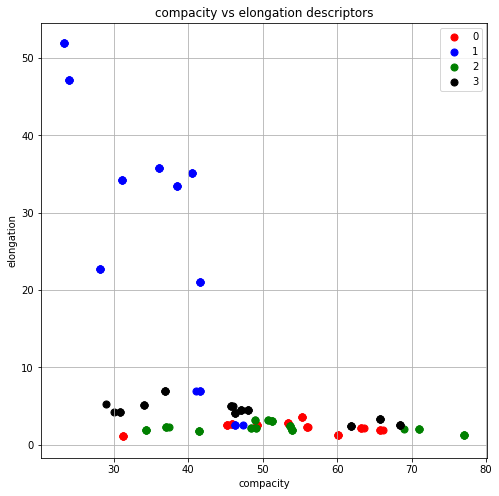

In [24]:
plotFeatures(compacity, elongation)

* __compacity__ vs __rectangularity__:<br />

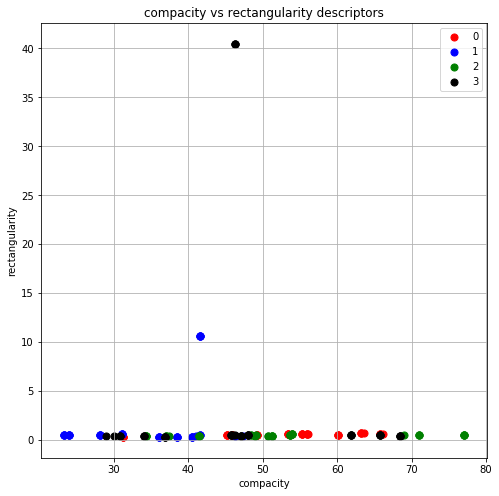

In [25]:
plotFeatures(compacity, rectangularity)

* __compacity__ vs __perimeter__:<br />

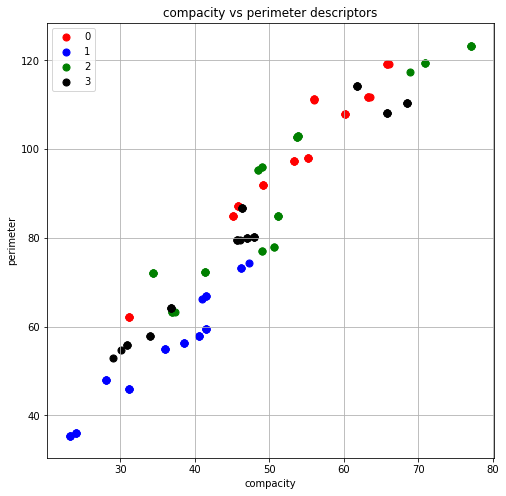

In [26]:
plotFeatures(compacity, perimeter)

##### 2.3.1.1 Discussion

According to the results obtained for four numbers, it is concluded that none of the selected pair of 
simple region based features could separate all four numbers. 

#### 2.3.2 Skeleton

Following the explained Skeleton based methods in part 1 we have:

##### 2.3.2.1 Medial-xis Skeletonization

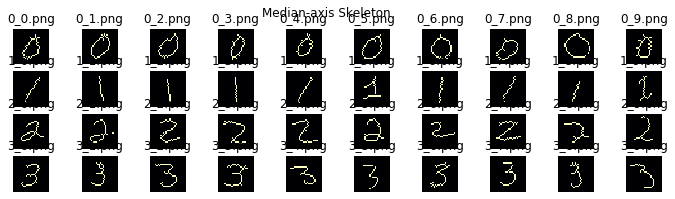

In [27]:
from skimage.morphology import medial_axis, skeletonize
import cv2
import numpy as np

skeleton_zero=[]
median_skeleton_zero=[]
median_skeleton_zero_r = []
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_zero_r.append(np.sum(r[r>1]))
    median_skeleton_zero.append(medial_axis(np_img))

skeleton_one=[]
median_skeleton_one = []
median_skeleton_one_r = []
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_one_r.append(np.sum(r[r>1]))
    median_skeleton_one.append(medial_axis(np_img))

skeleton_two=[]
median_skeleton_two = []
median_skeleton_two_r = []
Binary=[]
for im, nm in zip(twos_im, twos_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_two_r.append(np.sum(r[r>1]))
    median_skeleton_two.append(medial_axis(np_img))

skeleton_three=[]
median_skeleton_three = []
median_skeleton_three_r = []
Binary=[]
for im, nm in zip(threes_im, threes_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_three.append(skeletonize(np_img))
    skel, r = medial_axis(np_img, return_distance=True)
    median_skeleton_three_r.append(np.sum(r[r>1]))
    median_skeleton_three.append(medial_axis(np_img))


# Plotting the skeletons
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Median-axis Skeleton')
for ax, im, nm in zip(axes[0], median_skeleton_zero, zeros_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], median_skeleton_one, ones_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], median_skeleton_two, twos_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], median_skeleton_three, threes_names):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
    ax.set_title(nm)


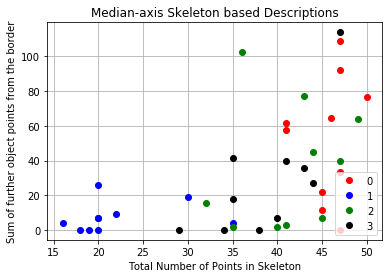

In [28]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=median_skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(median_skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
############################################################
# Removing the first and last rows and columns from images    
_,h,w= np.shape(median_skeleton_one)
h=h-1
w=w-1
skeleton_one_check=median_skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(median_skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 
############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_two)
h=h-1
w=w-1
skeleton_two_check=median_skeleton_two[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points2=[]
Total_number_of_corners2=[]

# Main for loop for feature extraction of twos
for im in np.arange(0,np.shape(median_skeleton_two)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_two[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_two[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points2.append(Number_of_points)
    Total_number_of_corners2.append(Number_of_corners)

############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_three)
h=h-1
w=w-1
skeleton_three_check=median_skeleton_three[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points3=[]
Total_number_of_corners3=[]

# Main for loop for feature extraction of threes
for im in np.arange(0,np.shape(median_skeleton_three)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_three[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_three[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points3.append(Number_of_points)
    Total_number_of_corners3.append(Number_of_corners)



# Plotting the features plot
Plot_zeros = plt.plot(Total_number_of_points0,median_skeleton_zero_r, "o", label="0", c='r')
Plot_ones = plt.plot(Total_number_of_points1,median_skeleton_one_r, "o", label="1", c='b')
Plot_twos = plt.plot(Total_number_of_points2,median_skeleton_two_r, "o", label="2", c='g')
Plot_threes = plt.plot(Total_number_of_points3,median_skeleton_three_r, "o", label="3", c='k')

plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Sum of further object points from the border')
plt.title('Median-axis Skeleton based Descriptions')
plt.grid(True)
plt.show()

The result indicates that the introduced two descriptors based on median-axis skeleton could not clearly separate all 
four object classes.

##### 2.3.2.2 Thinning Skeletonization


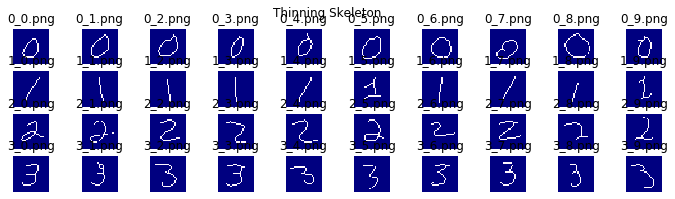

In [29]:
from skimage.morphology import medial_axis, skeletonize
import cv2
import numpy as np

skeleton_zero=[]
median_skeleton_zero=[]
Binary=[]
for im, nm in zip(zeros_im, zeros_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_zero.append(skeletonize(np_img))

skeleton_one=[]
Binary=[]
for im, nm in zip(ones_im, ones_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_one.append(skeletonize(np_img))

skeleton_two=[]
Binary=[]
for im, nm in zip(twos_im, twos_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_two.append(skeletonize(np_img))
    
skeleton_three=[]
Binary=[]
for im, nm in zip(threes_im, threes_names):
    # Transforming image to binary image
    ret,thresh = cv2.threshold(im,230,255,cv2.THRESH_BINARY)
    np_img = np.array(thresh)
    np_img[np_img > 0] = 1
    # Skeletonizing the image
    skeleton_three.append(skeletonize(np_img))

# Plotting the skeletons
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3)) 
plt.suptitle('Thinning Skeleton')
for ax, im, nm in zip(axes[0], skeleton_zero, zeros_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], skeleton_one, ones_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], skeleton_two, twos_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], skeleton_three, threes_names):
    ax.imshow(im, cmap='gist_ncar')
    ax.axis('off')
    ax.set_title(nm)


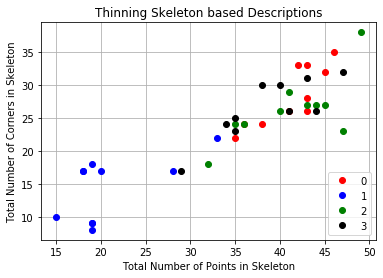

In [30]:
# Removing the first and last rows and columns from images
_,h,w= np.shape(skeleton_zero)
h=h-1
w=w-1
skeleton_zero_check=skeleton_zero[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points0=[]
Total_number_of_corners0=[]

# Main for loop for feature extraction of zeros
for im in np.arange(0,np.shape(skeleton_zero)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_zero[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_zero[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points0.append(Number_of_points)
    Total_number_of_corners0.append(Number_of_corners)
    
# Removing the first and last rows and columns from images    
_,h,w= np.shape(skeleton_one)
h=h-1
w=w-1
skeleton_one_check=skeleton_one[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points1=[]
Total_number_of_corners1=[]

# Main for loop for feature extraction of ones
for im in np.arange(0,np.shape(skeleton_one)[0],1):
    Number_of_points=0
    Number_of_corners=0
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if skeleton_one[im][x][y]==True:
                # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if skeleton_one[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1
    Total_number_of_points1.append(Number_of_points)
    Total_number_of_corners1.append(Number_of_corners) 
############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_two)
h=h-1
w=w-1
skeleton_two_check=median_skeleton_two[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points2=[]
Total_number_of_corners2=[]

# Main for loop for feature extraction of twos
for im in np.arange(0,np.shape(median_skeleton_two)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_two[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_two[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points2.append(Number_of_points)
    Total_number_of_corners2.append(Number_of_corners)

############################################################
# Removing the first and last rows and columns from images
_,h,w= np.shape(median_skeleton_three)
h=h-1
w=w-1
skeleton_three_check=median_skeleton_three[:][1:h][1:w]

# Initilizing the variables
Total_number_of_points3=[]
Total_number_of_corners3=[]

# Main for loop for feature extraction of threes
for im in np.arange(0,np.shape(median_skeleton_three)[0],1):
    Number_of_points=0
    Number_of_corners=0
    vertical_line=[]
    for x in np.arange(1,h,1):
        for y in np.arange(1,w,1):
            if median_skeleton_three[im][x][y]==True:
                 # Extracting the number of points
                Number_of_points=Number_of_points+1
                s=0
                for a in np.arange(-1,1,1):
                    for b in np.arange(-1,1,1):
                        if median_skeleton_three[im][x+a][y+b]== True:
                            s=s+1
                if s==2:
                    # Extracting the number of corners
                    Number_of_corners=Number_of_corners+1

    Total_number_of_points3.append(Number_of_points)
    Total_number_of_corners3.append(Number_of_corners)


# Plotting the features plot
Plot_zeros = plt.plot(Total_number_of_points0,Total_number_of_corners0, "o", label="0", c='r')
Plot_ones = plt.plot(Total_number_of_points1,Total_number_of_corners1, "o", label="1", c='b')
Plot_twos = plt.plot(Total_number_of_points2, Total_number_of_corners2, "o", label="2", c='g')
Plot_threes = plt.plot(Total_number_of_points3, Total_number_of_corners3, "o", label="3", c='k')

plt.legend(loc=4)
plt.xlabel('Total Number of Points in Skeleton')
plt.ylabel('Total Number of Corners in Skeleton')
plt.title('Thinning Skeleton based Descriptions')
plt.grid(True)
plt.show()

The result shows that utilizing two introduced thinning skeleton based descriptors is insufficient to discriminater
 four numbers from each other


